In [1]:
!conda env list

# conda environments:
#
base                     /home/theekshana/anaconda3
YOLO3D                *  /home/theekshana/anaconda3/envs/YOLO3D
sr                       /home/theekshana/anaconda3/envs/sr
stereo_rcnn              /home/theekshana/anaconda3/envs/stereo_rcnn



In [1]:
import sys
# sys.path.append("../")
import importlib
import os
import copy
import numpy as np
import matplotlib.pyplot as plt
import cv2
import cython
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms
import torchvision
from numba import jit
from tqdm import tqdm

In [2]:
from visualDet3D.data.kitti.utils import write_result_to_file
from visualDet3D.utils.utils import LossLogger, cfg_from_file
from visualDet3D.networks.utils.registry import DETECTOR_DICT, DATASET_DICT, PIPELINE_DICT
from visualDet3D.networks.heads.anchors import Anchors
from visualDet3D.networks.lib.fast_utils.hill_climbing import post_opt
from visualDet3D.networks.utils import BBox3dProjector, BackProjection
from visualDet3D.utils.utils import convertAlpha2Rot, convertRot2Alpha, draw_3D_box, compound_annotation
import visualDet3D.data.kitti.dataset
from visualDet3D.utils.timer import Timer

In [3]:
print('CUDA available: {}'.format(torch.cuda.is_available()))

cfg = cfg_from_file("config/config.py")
is_test_train = True

checkpoint_name = "Stereo3D_latest.pth"

CUDA available: True


In [4]:
# Read Conifg File
cfg.batch_size=1
split_to_test='validation'

# Define dataset_name
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset_name = cfg.data.train_dataset
elif split_to_test == 'test':
    dataset_name = cfg.data.test_dataset
else:
    dataset_name = cfg.data.val_dataset

# Make dataset
dataset = DATASET_DICT[dataset_name](
        cfg, split_to_test
        )

# Split train/validation data
if split_to_test=='training':
    dataset_val = DATASET_DICT[cfg.data.val_dataset](
            cfg, 'validation'
            )
    dataset.transform = dataset_val.transform
    dataset.collate_fn = dataset_val.collate_fn


In [5]:
# Build a detector network
detector = DETECTOR_DICT[cfg.detector.name](cfg.detector)
detector = detector.cuda()

# Tensor load by GPU
weight_path = os.path.join(cfg.path.checkpoint_path, checkpoint_name)
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))
new_dict = state_dict.copy()
for key in state_dict:
    if 'focalLoss' in key:
        new_dict.pop(key)

# Load the pre-trained model
detector.load_state_dict(new_dict, strict=False)
detector.eval().cuda()

# Testing pipeline
test_func = PIPELINE_DICT[cfg.trainer.test_func]

# Load projector and backprojector
projector = BBox3dProjector().cuda()
backprojector = BackProjection().cuda()

In [6]:
def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
    drawed_image = image.copy()
    for box2d in bboxes2d:
        cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
    return drawed_image

In [7]:
index = 0
def corner_homo2bbox(corner_homo):
    """
        corner_homo: [N, 8, 3]
    """
    min_xy  = torch.min(corner_homo[:, :, 0:2], dim=1)[0]
    max_xy  = torch.max(corner_homo[:, :, 0:2], dim=1)[0]
    min_xy[:, 0]  = torch.clamp(min_xy[:, 0], 0, cfg.rgb_shape[1])
    min_xy[:, 1]  = torch.clamp(min_xy[:, 1], 0, cfg.rgb_shape[0])
    max_xy[:, 0]  = torch.clamp(max_xy[:, 0], 0, cfg.rgb_shape[1])
    max_xy[:, 1]  = torch.clamp(max_xy[:, 1], 0, cfg.rgb_shape[0])
    return torch.cat([min_xy, max_xy], dim=1)

def denorm(image):
    new_image = np.array((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, dtype=np.uint8)
    return new_image

@jit(cache=True, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3] # Used to draw depth predictions
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image

In [8]:
def compute_once(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))
        plt.show()

    return np.clip(rgb_image, 0, 255)

In [9]:
def compute_once_3d_bounding_box_only(index, is_draw=True, is_test_train=True):
    name = "%06d" % index
#     print(name)
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())

            
    
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    if len(scores) > 0:
        
        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)
    if is_draw:
        plt.imshow(np.clip(rgb_image, 0, 255))
        

    return np.clip(rgb_image, 0, 255)

In [10]:
def show_3d_boxes(index):
    fig = plt.figure(figsize=(16,9))
    a = compute_once_3d_bounding_box_only(index, is_test_train=False, is_draw=True)

/home/theekshana/Documents/visualDet3D/visualDet3D/data/kitti/dataset/stereo_dataset.py:155: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525553989/work/torch/csrc/utils/tensor_new.cpp:230.)
  return torch.from_numpy(left_images).float(), torch.from_numpy(right_images).float(), torch.tensor(P2).float(), torch.tensor(P3).float(), label, bbox2ds, bbox3ds
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


PSM Cos Volume takes 0.008859634399414062 seconds at call time 1


/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


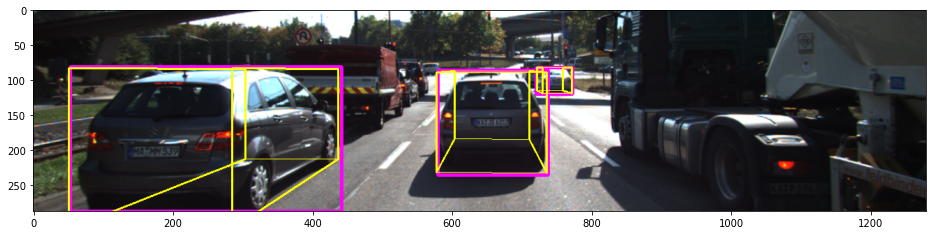

In [11]:
#%matplotlib inline
fig = plt.figure(figsize=(16,9))
index = 0
a = compute_once(index, is_test_train=False, is_draw=True)

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


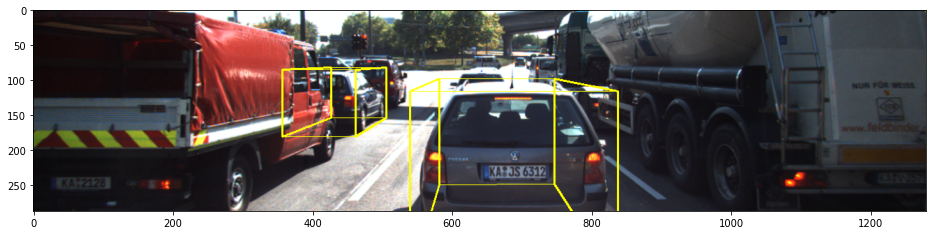

In [77]:
show_3d_boxes(76)

In [12]:
from IPython.display import clear_output

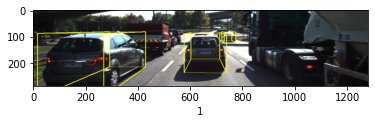

In [13]:
fig = plt.figure(figsize=(16,9))
for index in range(0,2):
    a = compute_once_3d_bounding_box_only(index, is_test_train=False, is_draw=False)
    clear_output(wait=True)
    plt.imshow(a, aspect=1)
#     print(cv2.imwrite(('{}.jpg'.format(index)), a))
    plt.xlabel(index)
    plt.show()

In [14]:
def get_predictions(index):
    name = "%06d" % index
    data = dataset[index]
    if isinstance(data['calib'], list):
        P2 = data['calib'][0]
    else:
        P2 = data['calib']
    original_height = data['original_shape'][0]
    collated_data = dataset.collate_fn([data])
    height = collated_data[0].shape[2]
    scale_2d = (original_height - cfg.data.augmentation.crop_top) / height
    
    if len(collated_data) > 6:
        left_images, right_images, _, _, labels, bbox_3d, _ = collated_data
    else:
        left_images, right_images, _, _, labels, bbox_3d = collated_data
    image = left_images

    with torch.no_grad():
        
        left_images, right_images, P2, P3 = collated_data[0], collated_data[1], collated_data[2], collated_data[3]
        scores, bbox, obj_names = detector([left_images.cuda().float().contiguous(),
                                          right_images.cuda().float().contiguous(),
                                          P2.cuda().float(),
                                          P3.cuda().float()])
        
        P2 = P2[0]
        bbox_2d = bbox[:, 0:4]
        bbox_3d_state = bbox[:, 4:] #[cx,cy,z,w,h,l,alpha]
        bbox_3d_state_3d = backprojector(bbox_3d_state, P2.cuda()) #[x, y, z, w,h ,l, alpha]
        abs_bbox, bbox_3d_corner_homo, thetas = projector(bbox_3d_state_3d, P2.cuda())
        
        rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
        
        return rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo
    
#     if len(scores) > 0:
#         rgb_image = draw_bbox2d_to_image(rgb_image, bbox_2d.cpu().numpy())
#         for box in bbox_3d_corner_homo:
#             box = box.cpu().numpy().T
#             rgb_image = draw_3D_box(rgb_image, box)
#     if is_draw:
#         plt.imshow(np.clip(rgb_image, 0, 255))
        
#     return np.clip(rgb_image, 0, 255)

In [15]:
from sort import *
#create instance of SORT
mot_tracker = Sort() 

In [16]:
def assignTrackID(index):
    # get detections
    rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(index)
    
    if len(scores) > 0:
        
        detectionsList=[]
        for i in range(len(scores)):
            detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
            detectionsList.append(detection)
        detectionsNumPyArray = np.asarray(detectionsList)
        # update SORT
        #  def update(self, dets=np.empty((0, 5))):
        """
            Params:
              dets - a numpy array of detections in the format [[x1,y1,x2,y2,score],[x1,y1,x2,y2,score],...]
            Requires: this method must be called once for each frame even with empty detections (use np.empty((0, 5)) for frames without detections).
            Returns the a similar array, where the last column is the object ID.

            NOTE: The number of objects returned may differ from the number of detections provided.
        """
        track_bbs_ids = mot_tracker.update(detectionsNumPyArray)
    # track_bbs_ids is a np array where each row contains a valid bounding box and track_id (last column)

        for box in bbox_3d_corner_homo:
            box = box.cpu().numpy().T
            rgb_image = draw_3D_box(rgb_image, box)

        for j in range(len(scores)):
            box1 = bbox_3d_corner_homo[j]
            box = box1.cpu().numpy().T
            trackID=track_bbs_ids[j][-1]
            rgb_image = draw_3D_box(rgb_image, box)
            x=int(box1[1][0].cpu().numpy())
            y=int(box1[1][1].cpu().numpy())
            name="ID: {}".format(str(trackID))

            # font
            font = cv2.FONT_HERSHEY_SIMPLEX
            # org
            org = (x, y-10)
            # fontScale
            fontScale = 0.9
            # Blue color in BGR
            color=(0, 255, 255)
            # Line thickness of 2 px
            thickness = 2
            # Using cv2.putText() method
            cv2.putText(rgb_image,name, org, font, fontScale, color, thickness, cv2.LINE_AA)

                
# def draw_bbox2d_to_image(image, bboxes2d, color=(255, 0, 255)):
#     drawed_image = image.copy()
#     for box2d in bboxes2d:
#         cv2.rectangle(drawed_image, (int(box2d[0]), int(box2d[1])), (int(box2d[2]), int(box2d[3])), color, 3)
#     return drawed_image
            
    return np.clip(rgb_image, 0, 255)

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


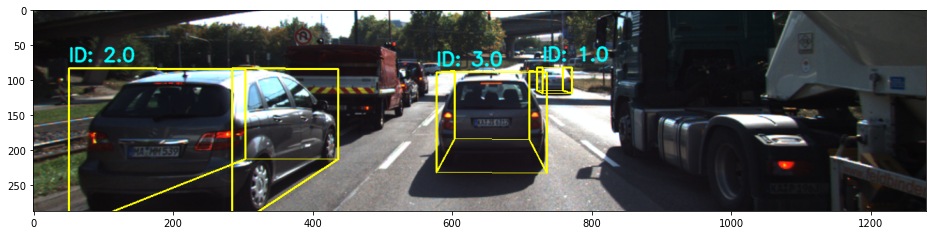

In [182]:
fig = plt.figure(figsize=(16,9))
index=0
plt.imshow(assignTrackID(0))

In [108]:
detectionsList=[]
for i in range(len(scores)):
    detection=np.append((bbox_2d[i]).cpu(),scores[i].cpu())
    detectionsList.append(detection)
detectionsNumPyArray = np.asarray(detectionsList)
track_bbs_ids = mot_tracker.update(detectionsNumPyArray)
print(track_bbs_ids)

[[721.84570312  82.13313293 773.55651856 120.03668213   3.        ]
 [ 53.04466399  81.88580402 442.95939485 287.9999992    2.        ]
 [580.19299334  86.56102006 738.23376448 236.25517257   1.        ]]


In [117]:
 rgb_image, scores, bbox_2d, obj_names, bbox_3d_corner_homo=get_predictions(0)

/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:87: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training
/home/theekshana/Documents/visualDet3D/visualDet3D/networks/lib/PSM_cost_volume.py:55: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  volatile= not self.training


In [142]:
print(bbox_3d_corner_homo.cpu().numpy().T)
        
print(int(bbox_3d_corner_homo[0][0][0].cpu().numpy()))
print(bbox_3d_corner_homo[0][0][0].cpu().int())
print(bbox_2d[0])

[[[736.6287     285.82977    772.7367    ]
  [578.8627      51.04395    730.4818    ]
  [578.8627      51.04395    730.4818    ]
  [604.18713    304.79547    722.6168    ]
  [604.18713    304.79547    722.6168    ]
  [711.0685     437.309      759.833     ]
  [711.0685     437.309      759.833     ]
  [736.6287     285.82977    772.7367    ]]

 [[ 89.33015     83.87725     82.61068   ]
  [ 89.29431     83.877396    82.614784  ]
  [232.14961    313.57788    119.23989   ]
  [184.58328    213.68239    115.09766   ]
  [ 87.691376    84.06692     82.81611   ]
  [ 87.707825    84.06687     82.81292   ]
  [185.07127    213.70676    115.16319   ]
  [233.21284    313.65442    119.32427   ]]

 [[  0.9999999    0.9999998    0.99999994]
  [  0.9999999    0.9999998    0.99999994]
  [  0.9999999    0.9999998    0.99999994]
  [  0.99999994   0.9999999    1.        ]
  [  0.99999994   0.9999999    1.        ]
  [  0.99999994   0.9999999    1.        ]
  [  0.99999994   0.9999999    1.        ]
  [  0.

In [122]:
print(bbox_3d_corner_homo[1])
print(bbox_2d[1])

tensor([[285.8298,  83.8773,   1.0000],
        [ 51.0439,  83.8774,   1.0000],
        [ 51.0439, 313.5779,   1.0000],
        [304.7955, 213.6824,   1.0000],
        [304.7955,  84.0669,   1.0000],
        [437.3090,  84.0669,   1.0000],
        [437.3090, 213.7068,   1.0000],
        [285.8298, 313.6544,   1.0000]], device='cuda:0')
tensor([ 53.0447,  81.8858, 442.9594, 288.0000], device='cuda:0')


In [123]:
print(bbox_3d_corner_homo[2])
print(bbox_2d[2])

tensor([[772.7367,  82.6107,   1.0000],
        [730.4818,  82.6148,   1.0000],
        [730.4818, 119.2399,   1.0000],
        [722.6168, 115.0977,   1.0000],
        [722.6168,  82.8161,   1.0000],
        [759.8330,  82.8129,   1.0000],
        [759.8330, 115.1632,   1.0000],
        [772.7367, 119.3243,   1.0000]], device='cuda:0')
tensor([721.8457,  82.1331, 773.5565, 120.0367], device='cuda:0')


In [120]:
print(scores[0].cpu().numpy())
print(bbox_2d[0].cpu().numpy())
print(obj_names[0].cpu().numpy())

0.9999943
[580.193    86.56102 738.23376 236.25517]
0


In [103]:
print(np.append((bbox_2d[0]).cpu(),scores[0].cpu()))

[580.193      86.56102   738.23376   236.25517     0.9999943]
